In [4]:
# %% [markdown]
# # 2_lorann — Fit LoRANN and evaluate Recall@K with strict dataset integrity checks

import sys
from pathlib import Path

# Locate repo root by finding methods/lorann.py upward from CWD
p = Path.cwd().resolve()
repo_root = None
for _ in range(6):
    if (p / "methods" / "lorann.py").exists():
        repo_root = p
        break
    p = p.parent

if repo_root is None:
    raise FileNotFoundError("Could not find methods/lorann.py in parent directories.")

METHODS_DIR = (repo_root / "methods").resolve()
if str(METHODS_DIR) not in sys.path:
    sys.path.insert(0, str(METHODS_DIR))

from lorann import LorannIndex, compute_dataset_id  # noqa: E402

# Optional sanity check
import lorann as _lorann_mod  # noqa: E402
print("Using lorann from:", _lorann_mod.__file__)

REPO_ROOT = repo_root

# %%
import json
import time
from datetime import datetime

import numpy as np

# -------- dataset params (must match data notebook) --------
DIM = 300                     # 50 / 100 / 200 / 300
N_BASE = 400_000
NQ_TOTAL = 100_000
NQ_TEST = 20_000
TOP_K_GT = 50
SEED = 42

EVAL_KS = [10]                # e.g. [10] or [10, 50]
# ----------------------------------------------------------

# -------- LoRANN params --------
N_CLUSTERS = 1024
RANK = 32
N_PROBE = 16
CANDIDATE_COUNT = 2000
MAX_TRAIN_PER_CLUSTER = 2048
MIN_TRAIN_PER_CLUSTER = 64

KMEANS_MAX_ITER = 50
KMEANS_BATCH_SIZE = 8192
RANDOMIZED_SVD = True
SVD_OVERSAMPLE = 8
SVD_N_ITER = 2
# -------------------------------

REPO_ROOT = Path("..").resolve()
ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()
ARTIFACTS_RUNS.mkdir(parents=True, exist_ok=True)

print("ARTIFACTS_DATA:", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS:", ARTIFACTS_RUNS)
print("DIM:", DIM, "| EVAL_KS:", EVAL_KS)

# %%
def _load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

def _try_meta(z: dict) -> dict:
    s = z.get("meta", None)
    if s is None:
        return {}
    try:
        return json.loads(str(s.item()))
    except Exception:
        return {}

def _require_one_match(pattern: str, dim: int) -> Path:
    # Unique match (no "latest"). Raises if ambiguous.
    matches = sorted(ARTIFACTS_DATA.glob(pattern))
    # Force dim filter by filename
    matches = [p for p in matches if f"glove{dim}d_" in p.name]
    if len(matches) != 1:
        names = [p.name for p in matches]
        raise FileNotFoundError(f"Expected exactly 1 match for dim={dim}, pattern={pattern}. Found: {names}")
    return matches[0]

def resolve_dataset_paths(dim: int) -> tuple[Path, Path, Path]:
    # Primary: exact expected filenames (with __ds prefix)
    ds_glob = f"glove{dim}d_queries_N{N_BASE}_nq{NQ_TOTAL}_test{NQ_TEST}_seed{SEED}__ds*.npz"
    q_path = _require_one_match(ds_glob, dim)

    # Use dataset_id suffix from queries filename to lock base/gt
    ds_suffix = q_path.name.split("__ds")[-1].replace(".npz", "")
    base_glob = f"glove{dim}d_base_N{N_BASE}__ds{ds_suffix}.npz"
    gt_glob = f"glove{dim}d_gt_test_N{N_BASE}_nq{NQ_TEST}_k{TOP_K_GT}_seed{SEED}__ds{ds_suffix}.npz"

    base_path = _require_one_match(base_glob, dim)
    gt_path = _require_one_match(gt_glob, dim)
    return base_path, q_path, gt_path

base_path, queries_path, gt_path = resolve_dataset_paths(DIM)

base_z = _load_npz(base_path)
queries_z = _load_npz(queries_path)
gt_z = _load_npz(gt_path)

print("Base  :", base_path.name, "| keys:", list(base_z.keys()))
print("Queries:", queries_path.name, "| keys:", list(queries_z.keys()))
print("GT    :", gt_path.name, "| keys:", list(gt_z.keys()))

# %%
# Strict integrity checks
base_meta = _try_meta(base_z)
q_meta = _try_meta(queries_z)
gt_meta = _try_meta(gt_z)

ds_base = str(base_z.get("dataset_id", base_meta.get("dataset_id", "")))
ds_q = str(queries_z.get("dataset_id", q_meta.get("dataset_id", "")))
ds_gt = str(gt_z.get("dataset_id", gt_meta.get("dataset_id", "")))

if not (ds_base and ds_q and ds_gt):
    raise RuntimeError("Missing dataset_id in one of artifacts. Regenerate data with updated 0_data notebook.")

if not (ds_base == ds_q == ds_gt):
    raise RuntimeError(f"dataset_id mismatch: base={ds_base}, queries={ds_q}, gt={ds_gt}")

q_idx_test = queries_z["q_idx_test"]
gt_q_idx_test = gt_z["q_idx_test"]
if not np.array_equal(q_idx_test, gt_q_idx_test):
    raise RuntimeError("q_idx_test mismatch between queries and gt. Artifacts are not comparable.")

X = base_z["X"]          # (N, d)
Xn = base_z["Xn"]        # (N, d), unit norm
Q_train = queries_z["Q_train"]
Q_test = queries_z["Q_test"]
gt_ids = gt_z["gt_ids"]  # (nq_test, TOP_K_GT)

K_MAX = max(EVAL_KS)
if gt_ids.shape[1] < K_MAX:
    raise RuntimeError(f"GT has only {gt_ids.shape[1]} neighbors. Need >= {K_MAX}.")

print(f"DATASET_ID: {ds_q}")
print(f"X: {X.shape} | Q_train: {Q_train.shape} | Q_test: {Q_test.shape} | GT: {gt_ids.shape}")

# %%
def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        hits += len(set(pred_ids[i, :k].tolist()) & set(gt_ids[i, :k].tolist()))
    return float(hits) / float(denom) if denom > 0 else 0.0

def ms_per_query(seconds: float, nq: int) -> float:
    return 1000.0 * float(seconds) / float(max(1, nq))

# %%
# Fit LoRANN
index = LorannIndex(
    n_clusters=N_CLUSTERS,
    rank=RANK,
    n_probe=N_PROBE,
    candidate_count=CANDIDATE_COUNT,
    max_train_per_cluster=MAX_TRAIN_PER_CLUSTER,
    min_train_per_cluster=MIN_TRAIN_PER_CLUSTER,
    seed=SEED,
    randomized_svd=RANDOMIZED_SVD,
    svd_oversample=SVD_OVERSAMPLE,
    svd_n_iter=SVD_N_ITER,
)

t0 = time.perf_counter()
index.fit(
    X=X,                 # corpus
    train_X=Q_train,     # query distribution proxy
    kmeans_max_iter=KMEANS_MAX_ITER,
    kmeans_batch_size=KMEANS_BATCH_SIZE,
)
t_fit = time.perf_counter() - t0

stats = getattr(index, "fit_stats_", {})
if stats:
    print("Fit stats:", stats)

print(f"Fit: {t_fit:.2f}s")

# %%
# Search (predict max K once, derive smaller K by prefix)
pred_k = int(max(EVAL_KS))
exclude_ids = q_idx_test.tolist()  # exclude self-match per query

t0 = time.perf_counter()
pred_ids, pred_scores = index.search_batch(
    Q_test,
    top_k=pred_k,
    candidate_count=CANDIDATE_COUNT,
    exclude_ids=exclude_ids,
)
t_search = time.perf_counter() - t0

print(f"Search: {t_search:.2f}s | {ms_per_query(t_search, Q_test.shape[0]):.3f} ms/query | pred_k={pred_k}")

for k in EVAL_KS:
    r = recall_at_k(pred_ids, gt_ids, k=int(k))
    print(f"Recall@{int(k)}: {r:.4f}")

# %%
# Save run artifact (locked to dataset_id)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = ARTIFACTS_RUNS / "lorann" / f"ds{ds_q}"
run_dir.mkdir(parents=True, exist_ok=True)

run_path = run_dir / (
    f"{ts}__d{DIM}__k{pred_k}"
    f"__nlist{N_CLUSTERS}__probe{N_PROBE}__cand{CANDIDATE_COUNT}__r{RANK}"
    f"__trainmax{MAX_TRAIN_PER_CLUSTER}__trainmin{MIN_TRAIN_PER_CLUSTER}.npz"
)

run_meta = {
    "method": "lorann",
    "dataset_id": ds_q,
    "dim": int(DIM),
    "pred_k": int(pred_k),
    "eval_ks": [int(k) for k in EVAL_KS],
    "n_clusters": int(N_CLUSTERS),
    "rank": int(RANK),
    "n_probe": int(N_PROBE),
    "candidate_count": int(CANDIDATE_COUNT),
    "max_train_per_cluster": int(MAX_TRAIN_PER_CLUSTER),
    "min_train_per_cluster": int(MIN_TRAIN_PER_CLUSTER),
    "kmeans_max_iter": int(KMEANS_MAX_ITER),
    "kmeans_batch_size": int(KMEANS_BATCH_SIZE),
    "randomized_svd": bool(RANDOMIZED_SVD),
    "svd_oversample": int(SVD_OVERSAMPLE),
    "svd_n_iter": int(SVD_N_ITER),
    "fit_seconds": float(t_fit),
    "search_seconds": float(t_search),
    "ms_per_query": float(ms_per_query(t_search, Q_test.shape[0])),
    "fit_stats": stats,
}

np.savez_compressed(
    run_path,
    dataset_id=np.array(ds_q, dtype=np.str_),
    pred_ids=pred_ids.astype(np.int32, copy=False),
    pred_scores=pred_scores.astype(np.float32, copy=False),
    meta=np.array(json.dumps(run_meta), dtype=np.str_),
)

print("Saved run:", run_path)


Using lorann from: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/methods/lorann.py
ARTIFACTS_DATA: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/data
ARTIFACTS_RUNS: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs
DIM: 300 | EVAL_KS: [10]
Base  : glove300d_base_N400000__ds989456bc6cc2e6ed.npz | keys: ['dataset_id', 'base_words', 'X', 'Xn', 'meta']
Queries: glove300d_queries_N400000_nq100000_test20000_seed42__ds989456bc6cc2e6ed.npz | keys: ['dataset_id', 'q_idx_all', 'q_idx_train', 'q_idx_test', 'Q_train', 'Q_test', 'Qn_train', 'Qn_test', 'meta']
GT    : glove300d_gt_test_N400000_nq20000_k50_seed42__ds989456bc6cc2e6ed.npz | keys: ['dataset_id', 'q_idx_test', 'gt_ids', 'gt_scores', 'meta']
DATASET_ID: 989456bc6cc2e6ed
X: (400000, 300) | Q_train: (80000, 300) | Q_test: (20000, 300) | GT: (20000, 50)
Fit stats: {'n_clusters': 1024, 'n_probe': 16, 'n_probe_train': 16, 'train_multi_assign': True, 'fallback_clusters': 31, 'fallback_fr

REPO_ROOT      : /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project
ARTIFACTS_DATA : /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/data
ARTIFACTS_RUNS : /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs
Found run files: 1
Best LoRANN run per dimension (by Recall@10):


,dim,recall@10,ms_per_query,nlist,n_probe,candidate_count,rank,run_file
0,300,0.7653,0.799853,1024,16,2000,32,20251221_174748__d300__k10__nlist1024__probe16...


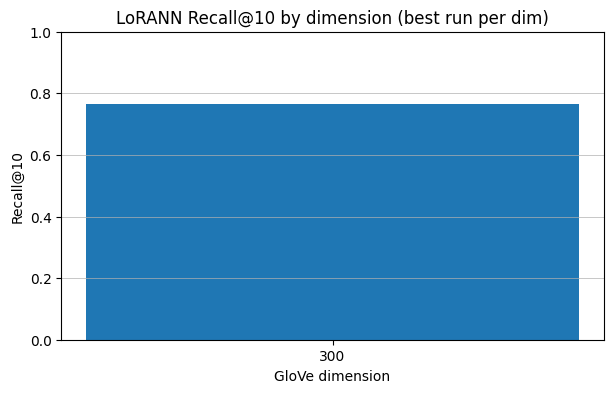

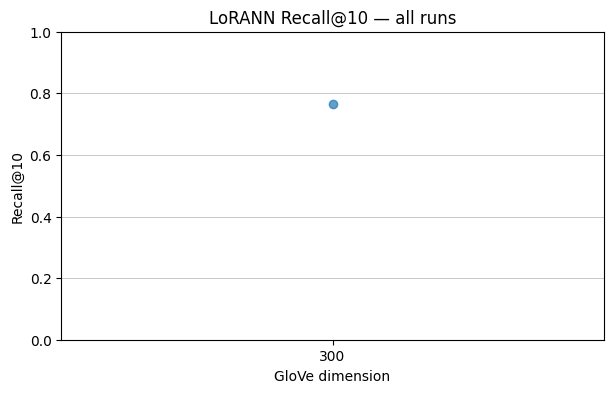

Saved: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs/lorann_eval_summary.csv


In [5]:
# %% [markdown]
# # 4_eval_runs — Aggregate LoRANN runs and plot Recall@10 across GloVe dimensions
# Assumptions:
# - Runs are saved under: artifacts/runs/lorann/ds<DATASET_ID>/*.npz
# - Each run .npz contains: pred_ids, pred_scores (optional), dataset_id, meta (json string)
# - Ground truth is saved under: artifacts/data/glove{dim}d_gt_test_...__ds<DATASET_ID>.npz
# - GT .npz contains: gt_ids, q_idx_test, dataset_id

# %%
import json
import re
from pathlib import Path
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %%
# ---- Resolve repo root robustly (find artifacts/ or methods/lorann.py) ----
p = Path.cwd().resolve()
REPO_ROOT = None
for _ in range(8):
    if (p / "artifacts").exists() or (p / "methods" / "lorann.py").exists():
        REPO_ROOT = p
        break
    p = p.parent

if REPO_ROOT is None:
    raise FileNotFoundError("Could not locate repo root (expected artifacts/ or methods/lorann.py in parents).")

ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()

if not ARTIFACTS_DATA.exists():
    raise FileNotFoundError(f"Data artifacts dir not found: {ARTIFACTS_DATA}")
if not ARTIFACTS_RUNS.exists():
    raise FileNotFoundError(f"Runs artifacts dir not found: {ARTIFACTS_RUNS}")

print("REPO_ROOT      :", REPO_ROOT)
print("ARTIFACTS_DATA :", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS :", ARTIFACTS_RUNS)

# %%
EVAL_K = 10
DIMS = [50, 100, 200, 300]  # expected dims

# %%
def _load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

def _meta_dict(z: dict) -> dict:
    s = z.get("meta", None)
    if s is None:
        return {}
    try:
        return json.loads(str(s.item()))
    except Exception:
        return {}

def _get_dataset_id(z: dict) -> str:
    # Handles both stored dataset_id and meta["dataset_id"]
    if "dataset_id" in z:
        try:
            return str(z["dataset_id"].item())
        except Exception:
            return str(z["dataset_id"])
    m = _meta_dict(z)
    return str(m.get("dataset_id", ""))

def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    """
    Set-based Recall@k averaged over queries:
      |pred ∩ gt| / k
    pred_ids may contain -1 placeholders.
    """
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    if k <= 0:
        return 0.0

    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        p = pred_ids[i, :k]
        g = gt_ids[i, :k]
        # remove -1 from preds
        ps = set(int(x) for x in p.tolist() if int(x) >= 0)
        gs = set(int(x) for x in g.tolist() if int(x) >= 0)
        hits += len(ps & gs)
    return float(hits) / float(denom)

def parse_timestamp_from_name(name: str) -> Optional[str]:
    # expects prefix like YYYYMMDD_HHMMSS__
    m = re.match(r"^(\d{8}_\d{6})__", name)
    return m.group(1) if m else None

# %%
# ---- Cache GT per (dataset_id, dim) to avoid re-loading repeatedly ----
_gt_cache: Dict[Tuple[str, int], Tuple[np.ndarray, np.ndarray]] = {}

def load_gt(dataset_id: str, dim: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns (gt_ids, q_idx_test) for a given dataset_id and dim.
    """
    key = (dataset_id, int(dim))
    if key in _gt_cache:
        return _gt_cache[key]

    pattern = f"glove{dim}d_gt_test_*__ds{dataset_id}.npz"
    matches = sorted(ARTIFACTS_DATA.glob(pattern))

    if len(matches) != 1:
        # fallback: allow older filenames without __ds (best-effort)
        fallback = sorted([p for p in ARTIFACTS_DATA.glob(f"glove{dim}d_gt_test_*.npz") if f"__ds{dataset_id}" in p.name])
        matches = fallback

    if len(matches) != 1:
        raise FileNotFoundError(f"Expected 1 GT file for dim={dim}, dataset_id={dataset_id}. Found: {[p.name for p in matches]}")

    z = _load_npz(matches[0])
    ds = _get_dataset_id(z)
    if ds != dataset_id:
        raise RuntimeError(f"GT dataset_id mismatch for dim={dim}: expected {dataset_id}, got {ds}")

    gt_ids = z["gt_ids"]
    q_idx_test = z["q_idx_test"]
    _gt_cache[key] = (gt_ids, q_idx_test)
    return gt_ids, q_idx_test

# %%
# ---- Find all LoRANN run files ----
lorann_root = ARTIFACTS_RUNS / "lorann"
if not lorann_root.exists():
    raise FileNotFoundError(f"No LoRANN runs found: {lorann_root}")

run_files = sorted(lorann_root.rglob("*.npz"))
print("Found run files:", len(run_files))

# %%
rows: List[dict] = []

for rp in run_files:
    try:
        rz = _load_npz(rp)
        rmeta = _meta_dict(rz)
        dataset_id = _get_dataset_id(rz)

        if not dataset_id:
            # Skip legacy runs with no dataset_id
            continue

        dim = int(rmeta.get("dim", -1))
        if dim <= 0:
            # attempt parse from filename: "__d300__"
            m = re.search(r"__d(\d+)__", rp.name)
            dim = int(m.group(1)) if m else -1

        if dim not in DIMS:
            continue

        pred_ids = rz.get("pred_ids", None)
        if pred_ids is None:
            continue

        pred_k = int(rmeta.get("pred_k", pred_ids.shape[1]))
        if pred_k < EVAL_K or pred_ids.shape[1] < EVAL_K:
            # can't compute Recall@10 properly
            continue

        gt_ids, q_idx_test = load_gt(dataset_id, dim)

        # Optional: ensure q_idx_test length matches
        if gt_ids.shape[0] != pred_ids.shape[0]:
            # Most common cause: run used different nq_test or wrong dataset pairing
            continue

        r10 = recall_at_k(pred_ids, gt_ids, EVAL_K)

        ts = parse_timestamp_from_name(rp.name)
        ms_q = float(rmeta.get("ms_per_query", np.nan))
        cand = int(rmeta.get("candidate_count", rmeta.get("cand", -1))) if isinstance(rmeta, dict) else -1
        nprobe = int(rmeta.get("n_probe", -1))
        nlist = int(rmeta.get("n_clusters", -1))
        rank = int(rmeta.get("rank", -1))

        rows.append({
            "dataset_id": dataset_id,
            "dim": dim,
            "run_path": str(rp),
            "run_file": rp.name,
            "timestamp": ts,
            "recall@10": r10,
            "ms_per_query": ms_q,
            "nlist": nlist,
            "n_probe": nprobe,
            "candidate_count": cand,
            "rank": rank,
        })
    except Exception:
        # Skip any run that can't be parsed cleanly
        continue

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No valid LoRANN runs found that can be evaluated for Recall@10.")

# Sort for readability
df = df.sort_values(["dim", "recall@10", "timestamp"], ascending=[True, False, False]).reset_index(drop=True)
df.head(10)

# %%
# Show the best run per dimension (highest Recall@10; tie-break latest timestamp)
best = (
    df.sort_values(["dim", "recall@10", "timestamp"], ascending=[True, False, False])
      .groupby("dim", as_index=False)
      .head(1)
      .sort_values("dim")
      .reset_index(drop=True)
)

print("Best LoRANN run per dimension (by Recall@10):")
display(best[["dim", "recall@10", "ms_per_query", "nlist", "n_probe", "candidate_count", "rank", "run_file"]])

# %%
# Plot Recall@10 across dims (best run per dim)
dims = best["dim"].to_list()
vals = best["recall@10"].to_list()

plt.figure(figsize=(7, 4))
plt.bar([str(d) for d in dims], vals)
plt.xlabel("GloVe dimension")
plt.ylabel("Recall@10")
plt.title("LoRANN Recall@10 by dimension (best run per dim)")
plt.ylim(0, 1)
plt.grid(axis="y", linewidth=0.5)
plt.show()

# %%
# Optional: if you want to see ALL runs per dimension (scatter)
plt.figure(figsize=(7, 4))
for d in sorted(df["dim"].unique()):
    sub = df[df["dim"] == d]
    plt.scatter([str(d)] * len(sub), sub["recall@10"].to_numpy(), label=str(d), alpha=0.7)
plt.xlabel("GloVe dimension")
plt.ylabel("Recall@10")
plt.title("LoRANN Recall@10 — all runs")
plt.ylim(0, 1)
plt.grid(axis="y", linewidth=0.5)
plt.show()

# %%
# Save aggregated results
out_csv = (ARTIFACTS_RUNS / "lorann_eval_summary.csv").resolve()
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Using lorann from: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/methods/lorann.py
ARTIFACTS_DATA: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/data
ARTIFACTS_RUNS: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs
SWEEP_DIR: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs/lorann_sweeps/20251221_174817

=== DIM 100 | dataset_id=989456bc6cc2e6ed | runs=41 ===
X: (400000, 100) | Q_train: (80000, 100) | Q_test: (20000, 100)
[dim=100 001/41] nlist=4096 probe=1 cand=200 r=8 | fit=11.33s search=0.067ms/q recall@10=0.3664 (fallback_frac=0.650)
[dim=100 002/41] nlist=4096 probe=2 cand=200 r=8 | fit=9.52s search=0.080ms/q recall@10=0.4920 (fallback_frac=0.427)
[dim=100 003/41] nlist=4096 probe=2 cand=500 r=16 | fit=9.77s search=0.112ms/q recall@10=0.5080 (fallback_frac=0.427)
[dim=100 004/41] nlist=2048 probe=2 cand=200 r=8 | fit=5.80s search=0.075ms/q recall@10=0.5015 (fallback_frac=0.160)
[dim=100 005/41] nlist

,timestamp,dim,dataset_id,n_clusters,rank,n_probe,candidate_count,n_probe_train,train_multi_assign,fit_seconds,search_seconds,ms_per_query,recall@10,fallback_frac,avg_train_per_cluster,min_train_per_cluster_observed,max_train_per_cluster_observed
0,20251221_174817,100,989456bc6cc2e6ed,512,64,128,10000,512,True,15.554278,82.323785,4.116189,0.995815,0.000000,80000.0,80000,80000
1,20251221_174817,100,989456bc6cc2e6ed,1024,64,128,8000,512,True,24.501124,64.066004,3.203300,0.991695,0.000000,40000.0,6641,70326
2,20251221_174817,100,989456bc6cc2e6ed,512,64,64,8000,256,True,14.002059,52.368743,2.618437,0.986790,0.000000,40000.0,6763,70076
3,20251221_174817,100,989456bc6cc2e6ed,1024,96,64,10000,256,True,31.074513,60.157460,3.007873,0.977200,0.000000,20000.0,4594,60461
4,20251221_174817,100,989456bc6cc2e6ed,1024,64,64,6000,256,True,22.064952,40.017854,2.000893,0.977195,0.000000,20000.0,4594,60461
5,20251221_174817,100,989456bc6cc2e6ed,2048,64,64,4000,256,True,32.334459,25.348743,1.267437,0.965670,0.003418,10000.0,1471,53930
6,20251221_174817,100,989456bc6cc2e6ed,2048,96,64,8000,256,True,43.117719,43.110505,2.155525,0.965670,0.003418,10000.0,1471,53930
7,20251221_174817,100,989456bc6cc2e6ed,512,96,32,10000,128,True,18.807263,49.535268,2.476763,0.964555,0.000000,20000.0,5220,59711
8,20251221_174817,100,989456bc6cc2e6ed,512,32,32,4000,128,True,8.478467,24.354929,1.217746,0.958915,0.000000,20000.0,5220,59711
9,20251221_174817,100,989456bc6cc2e6ed,1024,96,32,8000,128,True,29.564433,39.256282,1.962814,0.947410,0.000000,10000.0,1806,49771



Best per dimension:


,dim,recall@10,ms_per_query,fit_seconds,n_clusters,n_probe,candidate_count,rank,n_probe_train,fallback_frac
0,100,0.995815,4.116189,15.554278,512,128,10000,64,512,0.0
1,200,0.982375,5.474555,16.787707,512,128,10000,64,512,0.0
2,300,0.968530,6.263266,16.514220,512,128,10000,64,512,0.0


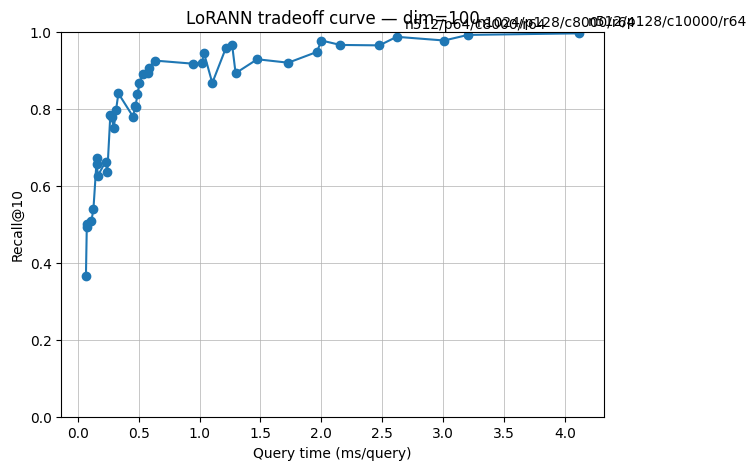

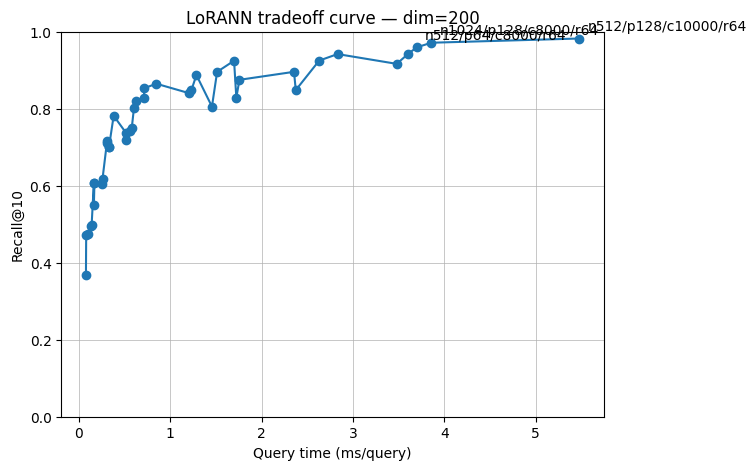

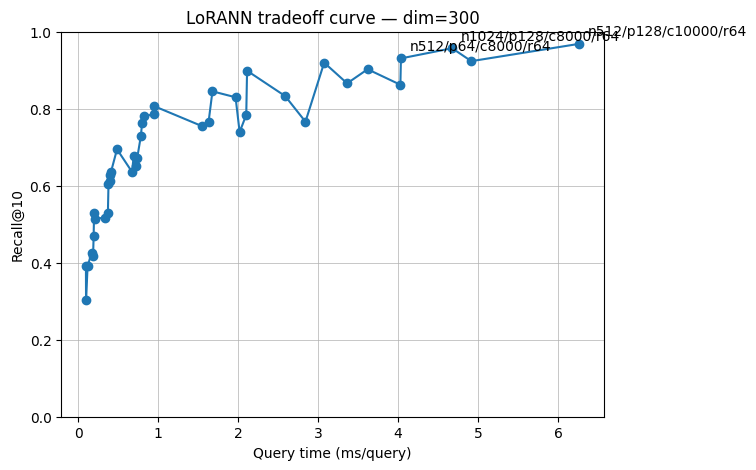

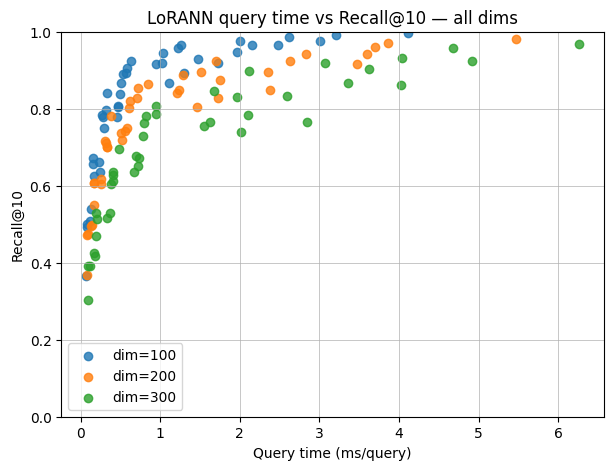

In [6]:
# %% [code]
import sys
import json
import time
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Locate repo root + import lorann
# ----------------------------
p = Path.cwd().resolve()
repo_root = None
for _ in range(8):
    if (p / "methods" / "lorann.py").exists() and (p / "artifacts").exists():
        repo_root = p
        break
    p = p.parent
if repo_root is None:
    raise FileNotFoundError("Could not locate repo root (expected methods/lorann.py and artifacts/).")

METHODS_DIR = (repo_root / "methods").resolve()
if str(METHODS_DIR) not in sys.path:
    sys.path.insert(0, str(METHODS_DIR))

from lorann import LorannIndex  # noqa: E402
import lorann as _lorann_mod    # noqa: E402
print("Using lorann from:", _lorann_mod.__file__)

REPO_ROOT = repo_root
ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()
ARTIFACTS_RUNS.mkdir(parents=True, exist_ok=True)
print("ARTIFACTS_DATA:", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS:", ARTIFACTS_RUNS)

# ----------------------------
# Dataset config (must match your 0_data notebook)
# ----------------------------
DIMS = [100, 200, 300]
N_BASE = 400_000
NQ_TOTAL = 100_000
NQ_TEST = 20_000
TOP_K_GT = 50
SEED = 42

EVAL_K = 10         # Recall@10
PRED_K = 10         # predict exactly 10 (keeps runs small)

# ----------------------------
# Fixed LoRANN training knobs (keep fixed for a clean sweep)
# ----------------------------
MAX_TRAIN_PER_CLUSTER = 2048
MIN_TRAIN_PER_CLUSTER = 64

KMEANS_MAX_ITER = 50
KMEANS_BATCH_SIZE = 8192

RANDOMIZED_SVD = True
SVD_OVERSAMPLE = 8
SVD_N_ITER = 2

TRAIN_MULTI_ASSIGN = True
N_PROBE_TRAIN_MULT = 4  # n_probe_train = min(N_PROBE_TRAIN_MULT * n_probe, n_clusters)

# ----------------------------
# Sweep grid (40 combos)
# You can replace this grid with your own.
# ----------------------------
PARAM_GRID_40 = [
    # ---------------- VERY FAST (low probe, low candidates, low rank) ----------------
    dict(n_clusters=4096, rank=8,  n_probe=1,  candidate_count=200),
    dict(n_clusters=4096, rank=8,  n_probe=2,  candidate_count=200),
    dict(n_clusters=4096, rank=16, n_probe=2,  candidate_count=500),
    dict(n_clusters=2048, rank=8,  n_probe=2,  candidate_count=200),
    dict(n_clusters=2048, rank=16, n_probe=4,  candidate_count=500),
    dict(n_clusters=1024, rank=8,  n_probe=2,  candidate_count=500),
    dict(n_clusters=1024, rank=16, n_probe=4,  candidate_count=500),
    dict(n_clusters=512,  rank=8,  n_probe=4,  candidate_count=500),

    # ---------------- FAST → MID (increase one knob at a time) ----------------
    dict(n_clusters=4096, rank=16, n_probe=4,  candidate_count=1000),
    dict(n_clusters=2048, rank=16, n_probe=4,  candidate_count=1000),
    dict(n_clusters=1024, rank=16, n_probe=8,  candidate_count=1000),
    dict(n_clusters=512,  rank=16, n_probe=8,  candidate_count=1000),

    # ---------------- MID (balanced) ----------------
    dict(n_clusters=4096, rank=32, n_probe=8,  candidate_count=1000),
    dict(n_clusters=2048, rank=32, n_probe=8,  candidate_count=1000),
    dict(n_clusters=1024, rank=32, n_probe=8,  candidate_count=2000),
    dict(n_clusters=512,  rank=32, n_probe=8,  candidate_count=2000),

    dict(n_clusters=4096, rank=32, n_probe=16, candidate_count=1000),
    dict(n_clusters=2048, rank=32, n_probe=16, candidate_count=2000),
    dict(n_clusters=1024, rank=32, n_probe=16, candidate_count=2000),
    dict(n_clusters=512,  rank=32, n_probe=16, candidate_count=4000),

    dict(n_clusters=2048, rank=64, n_probe=8,  candidate_count=2000),
    dict(n_clusters=1024, rank=64, n_probe=8,  candidate_count=2000),
    dict(n_clusters=1024, rank=64, n_probe=16, candidate_count=2000),
    dict(n_clusters=512,  rank=64, n_probe=16, candidate_count=4000),

    # ---------------- HIGH RECALL (push probes OR candidates strongly) ----------------
    # High probes, moderate candidates
    dict(n_clusters=4096, rank=32, n_probe=32, candidate_count=2000),
    dict(n_clusters=2048, rank=32, n_probe=32, candidate_count=2000),
    dict(n_clusters=1024, rank=32, n_probe=32, candidate_count=4000),
    dict(n_clusters=512,  rank=32, n_probe=32, candidate_count=4000),

    # Moderate probes, high candidates
    dict(n_clusters=2048, rank=64, n_probe=16, candidate_count=6000),
    dict(n_clusters=1024, rank=64, n_probe=16, candidate_count=6000),
    dict(n_clusters=512,  rank=64, n_probe=16, candidate_count=8000),

    # High probes + high candidates (slow but should boost recall)
    dict(n_clusters=2048, rank=64, n_probe=64,  candidate_count=4000),
    dict(n_clusters=1024, rank=64, n_probe=64,  candidate_count=6000),
    dict(n_clusters=512,  rank=64, n_probe=64,  candidate_count=8000),

    # ---------------- EXTREMES (to stretch the curve) ----------------
    # Very high rank (still <= 96), very high probes/candidates
    dict(n_clusters=2048, rank=96, n_probe=32,  candidate_count=6000),
    dict(n_clusters=1024, rank=96, n_probe=32,  candidate_count=8000),
    dict(n_clusters=512,  rank=96, n_probe=32,  candidate_count=10000),

    dict(n_clusters=2048, rank=96, n_probe=64,  candidate_count=8000),
    dict(n_clusters=1024, rank=96, n_probe=64,  candidate_count=10000),

    # Hardest / slowest configs (max spread)
    dict(n_clusters=1024, rank=64, n_probe=128, candidate_count=8000),
    dict(n_clusters=512,  rank=64, n_probe=128, candidate_count=10000),
]

PARAM_GRID = PARAM_GRID_40

# Optionally limit runs per dimension (set None to run all)
MAX_COMBOS_PER_DIM: Optional[int] = None  # e.g. 40, 20, 10, or None

# ----------------------------
# Helpers: artifact loading + strict integrity checks
# ----------------------------
def _load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

def _try_meta(z: dict) -> dict:
    s = z.get("meta", None)
    if s is None:
        return {}
    try:
        return json.loads(str(s.item()))
    except Exception:
        return {}

def _get_dataset_id(z: dict) -> str:
    if "dataset_id" in z:
        try:
            return str(z["dataset_id"].item())
        except Exception:
            return str(z["dataset_id"])
    m = _try_meta(z)
    return str(m.get("dataset_id", ""))

def _require_one_match(pattern: str, dim: int) -> Path:
    matches = sorted(ARTIFACTS_DATA.glob(pattern))
    matches = [p for p in matches if f"glove{dim}d_" in p.name]
    if len(matches) != 1:
        raise FileNotFoundError(f"Expected exactly 1 match for dim={dim}, pattern={pattern}. Found: {[p.name for p in matches]}")
    return matches[0]

def resolve_dataset_paths(dim: int) -> Tuple[Path, Path, Path]:
    q_glob = f"glove{dim}d_queries_N{N_BASE}_nq{NQ_TOTAL}_test{NQ_TEST}_seed{SEED}__ds*.npz"
    q_path = _require_one_match(q_glob, dim)

    ds_suffix = q_path.name.split("__ds")[-1].replace(".npz", "")
    base_glob = f"glove{dim}d_base_N{N_BASE}__ds{ds_suffix}.npz"
    gt_glob = f"glove{dim}d_gt_test_N{N_BASE}_nq{NQ_TEST}_k{TOP_K_GT}_seed{SEED}__ds{ds_suffix}.npz"

    base_path = _require_one_match(base_glob, dim)
    gt_path = _require_one_match(gt_glob, dim)
    return base_path, q_path, gt_path

def recall_at_k_set(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    """
    Set-based Recall@k averaged over queries:
      |pred ∩ gt| / k
    pred_ids can contain -1 placeholders.
    """
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    if k <= 0:
        return 0.0
    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        p = pred_ids[i, :k]
        g = gt_ids[i, :k]
        ps = set(int(x) for x in p.tolist() if int(x) >= 0)
        gs = set(int(x) for x in g.tolist() if int(x) >= 0)
        hits += len(ps & gs)
    return float(hits) / float(denom)

def ms_per_query(seconds: float, nq: int) -> float:
    return 1000.0 * float(seconds) / float(max(1, nq))

# ----------------------------
# Run sweep
# ----------------------------
ts_root = datetime.now().strftime("%Y%m%d_%H%M%S")
sweep_dir = (ARTIFACTS_RUNS / "lorann_sweeps" / ts_root).resolve()
sweep_dir.mkdir(parents=True, exist_ok=True)
print("SWEEP_DIR:", sweep_dir)

results: List[dict] = []

for dim in DIMS:
    base_path, queries_path, gt_path = resolve_dataset_paths(dim)
    base_z = _load_npz(base_path)
    queries_z = _load_npz(queries_path)
    gt_z = _load_npz(gt_path)

    ds_base = _get_dataset_id(base_z)
    ds_q = _get_dataset_id(queries_z)
    ds_gt = _get_dataset_id(gt_z)
    if not (ds_base and ds_q and ds_gt and ds_base == ds_q == ds_gt):
        raise RuntimeError(f"[dim={dim}] dataset_id mismatch: base={ds_base}, queries={ds_q}, gt={ds_gt}")

    q_idx_test = queries_z["q_idx_test"]
    gt_q_idx_test = gt_z["q_idx_test"]
    if not np.array_equal(q_idx_test, gt_q_idx_test):
        raise RuntimeError(f"[dim={dim}] q_idx_test mismatch between queries and gt artifacts.")

    # Use Xn if present, else X
    X = base_z["Xn"] if "Xn" in base_z else base_z["X"]
    Q_train = queries_z["Q_train"]
    Q_test = queries_z["Q_test"]
    gt_ids = gt_z["gt_ids"]

    if gt_ids.shape[1] < EVAL_K:
        raise RuntimeError(f"[dim={dim}] GT has only {gt_ids.shape[1]} neighbors, need >= {EVAL_K}.")

    exclude_ids = q_idx_test.tolist()  # exclude self-match (query vector belongs to corpus)

    grid = PARAM_GRID if MAX_COMBOS_PER_DIM is None else PARAM_GRID[: int(MAX_COMBOS_PER_DIM)]
    print(f"\n=== DIM {dim} | dataset_id={ds_q} | runs={len(grid)} ===")
    print(f"X: {X.shape} | Q_train: {Q_train.shape} | Q_test: {Q_test.shape}")

    for run_i, cfg in enumerate(grid, start=1):
        n_clusters = int(cfg["n_clusters"])
        rank = int(cfg["rank"])
        n_probe = int(cfg["n_probe"])
        cand = int(cfg["candidate_count"])

        # Safety: ensure rank <= dim (you excluded dim=50 for this reason)
        if rank > dim:
            print(f"Skipping cfg rank={rank} > dim={dim}")
            continue

        n_probe_train = int(min(N_PROBE_TRAIN_MULT * n_probe, n_clusters))

        # Build index
        index = LorannIndex(
            n_clusters=n_clusters,
            rank=rank,
            n_probe=n_probe,
            candidate_count=cand,
            max_train_per_cluster=MAX_TRAIN_PER_CLUSTER,
            min_train_per_cluster=MIN_TRAIN_PER_CLUSTER,
            seed=SEED,
            randomized_svd=RANDOMIZED_SVD,
            svd_oversample=SVD_OVERSAMPLE,
            svd_n_iter=SVD_N_ITER,
        )

        t0 = time.perf_counter()
        index.fit(
            X=X,
            train_X=Q_train,
            kmeans_max_iter=KMEANS_MAX_ITER,
            kmeans_batch_size=KMEANS_BATCH_SIZE,
            n_probe_train=n_probe_train,
            train_multi_assign=TRAIN_MULTI_ASSIGN,
        )
        fit_s = time.perf_counter() - t0
        fit_stats = getattr(index, "fit_stats_", {}) or {}

        # Search
        t0 = time.perf_counter()
        pred_ids, pred_scores = index.search_batch(
            Q_test,
            top_k=PRED_K,
            candidate_count=cand,
            exclude_ids=exclude_ids,
        )
        search_s = time.perf_counter() - t0
        ms_q = ms_per_query(search_s, Q_test.shape[0])

        r10 = recall_at_k_set(pred_ids, gt_ids, k=EVAL_K)

        row = {
            "timestamp": ts_root,
            "dim": int(dim),
            "dataset_id": str(ds_q),
            "n_clusters": n_clusters,
            "rank": rank,
            "n_probe": n_probe,
            "candidate_count": cand,
            "n_probe_train": n_probe_train,
            "train_multi_assign": bool(TRAIN_MULTI_ASSIGN),

            "fit_seconds": float(fit_s),
            "search_seconds": float(search_s),
            "ms_per_query": float(ms_q),
            f"recall@{EVAL_K}": float(r10),

            # Useful training diagnostics (why recall/latency changes)
            "fallback_frac": float(fit_stats.get("fallback_frac", np.nan)),
            "avg_train_per_cluster": float(fit_stats.get("avg_train_per_cluster", np.nan)),
            "min_train_per_cluster_observed": int(fit_stats.get("min_train_per_cluster_observed", -1)),
            "max_train_per_cluster_observed": int(fit_stats.get("max_train_per_cluster_observed", -1)),
        }
        results.append(row)

        # Save per-run JSON (small, good for audit / debugging)
        run_meta = dict(row)
        run_meta["fit_stats_full"] = fit_stats
        meta_path = sweep_dir / f"dim{dim}__run{run_i:03d}__nlist{n_clusters}__probe{n_probe}__cand{cand}__r{rank}.json"
        meta_path.write_text(json.dumps(run_meta, indent=2), encoding="utf-8")

        print(
            f"[dim={dim} {run_i:03d}/{len(grid)}] "
            f"nlist={n_clusters} probe={n_probe} cand={cand} r={rank} | "
            f"fit={fit_s:.2f}s search={ms_q:.3f}ms/q recall@{EVAL_K}={r10:.4f} "
            f"(fallback_frac={row['fallback_frac']:.3f})"
        )

        # Incremental CSV checkpoint (so you don't lose progress)
        df_tmp = pd.DataFrame(results)
        df_tmp.to_csv(sweep_dir / "lorann_sweep_results.csv", index=False)

# ----------------------------
# Results table
# ----------------------------
df = pd.DataFrame(results)
if df.empty:
    raise RuntimeError("No results collected. Check artifact paths and grid settings.")

df = df.sort_values(["dim", f"recall@{EVAL_K}", "ms_per_query"], ascending=[True, False, True]).reset_index(drop=True)
csv_path = sweep_dir / "lorann_sweep_results.csv"
parq_path = sweep_dir / "lorann_sweep_results.parquet"
df.to_csv(csv_path, index=False)
df.to_parquet(parq_path, index=False)
print("\nSaved results:")
print(" -", csv_path)
print(" -", parq_path)

display(df.head(20))

# Best config per dim (highest recall, tie-break by faster query time)
best = (
    df.sort_values(["dim", f"recall@{EVAL_K}", "ms_per_query"], ascending=[True, False, True])
      .groupby("dim", as_index=False)
      .head(1)
      .reset_index(drop=True)
)
print("\nBest per dimension:")
display(best[["dim", f"recall@{EVAL_K}", "ms_per_query", "fit_seconds", "n_clusters", "n_probe", "candidate_count", "rank", "n_probe_train", "fallback_frac"]])

# ----------------------------
# Plots: query time vs Recall@10 curve for each dataset dimension
# ----------------------------
for dim in sorted(df["dim"].unique()):
    sub = df[df["dim"] == dim].copy()
    sub = sub.sort_values("ms_per_query").reset_index(drop=True)

    plt.figure(figsize=(7, 5))
    plt.plot(sub["ms_per_query"].to_numpy(), sub[f"recall@{EVAL_K}"].to_numpy(), marker="o")
    plt.xlabel("Query time (ms/query)")
    plt.ylabel(f"Recall@{EVAL_K}")
    plt.title(f"LoRANN tradeoff curve — dim={dim}")
    plt.grid(True, linewidth=0.5)
    plt.ylim(0, 1)

    # Annotate a few best recall points (top 3)
    top3 = sub.sort_values([f"recall@{EVAL_K}", "ms_per_query"], ascending=[False, True]).head(3)
    for _, r in top3.iterrows():
        label = f"n{int(r['n_clusters'])}/p{int(r['n_probe'])}/c{int(r['candidate_count'])}/r{int(r['rank'])}"
        plt.annotate(label, (r["ms_per_query"], r[f"recall@{EVAL_K}"]), textcoords="offset points", xytext=(6, 6))

    plt.show()

# Optional: combined scatter (one figure, colored by dim)
plt.figure(figsize=(7, 5))
for dim in sorted(df["dim"].unique()):
    sub = df[df["dim"] == dim]
    plt.scatter(sub["ms_per_query"].to_numpy(), sub[f"recall@{EVAL_K}"].to_numpy(), label=f"dim={dim}", alpha=0.8)
plt.xlabel("Query time (ms/query)")
plt.ylabel(f"Recall@{EVAL_K}")
plt.title("LoRANN query time vs Recall@10 — all dims")
plt.grid(True, linewidth=0.5)
plt.ylim(0, 1)
plt.legend()
plt.show()
